# PSI Spike 二分类预测

预测未来 1 秒内 SOME 压力增量是否会暴增超过阈值（90th 分位数）。

**Pipeline**: 数据加载 → 标签构造 → Session-aware 分割 → 类别不平衡处理 → XGBoost 二分类 → Optuna 调参 → 评估

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# 中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

In [15]:
# ==================== 加载数据 ====================
df = pd.read_csv("../processed_data/processed_psi_douyin.csv")
print(f"数据: {len(df)} 行, {len(df.columns)} 列")
print(f"Sessions: {df['source_file'].nunique()} 个")
print(df.groupby('source_file').size())

# 确认无 phase/ts 泄漏
for col in ['phase', 'ts']:
    assert col not in df.columns, f"发现泄漏列: {col}"
print("\n✓ 无 phase/ts 泄漏")

数据: 10826 行, 66 列
Sessions: 9 个
source_file
psi_douyin_20260228_211328.csv     997
psi_douyin_20260228_213146.csv    1241
psi_douyin_20260228_215103.csv    1220
psi_douyin_20260228_221442.csv    1225
psi_douyin_20260301_203427.csv    1256
psi_douyin_20260301_205453.csv    1208
psi_douyin_20260301_211527.csv    1220
psi_douyin_20260301_213426.csv    1216
psi_douyin_20260301_220936.csv    1243
dtype: int64

✓ 无 phase/ts 泄漏


In [16]:
# ==================== 构造二分类标签 ====================
# 绝对阈值：未来 1s SOME 增量超过 100ms (100,000μs) 视为 spike
THRESHOLD = 100000

df['is_spike'] = (df['future_1s_some'] > THRESHOLD).astype(int)

print(f"Spike 阈值 (绝对): {THRESHOLD} μs (100ms)")
print(f"正样本 (spike=1): {df['is_spike'].sum()} ({df['is_spike'].mean():.2%})")
print(f"负样本 (spike=0): {(1 - df['is_spike']).sum()} ({1 - df['is_spike'].mean():.2%})")

# 各 session 的 spike 分布
print("\n各 session spike 比例:")
print(df.groupby('source_file')['is_spike'].mean().round(4))

Spike 阈值 (绝对): 100000 μs (100ms)
正样本 (spike=1): 1021 (9.43%)
负样本 (spike=0): 9805 (90.57%)

各 session spike 比例:
source_file
psi_douyin_20260228_211328.csv    0.1093
psi_douyin_20260228_213146.csv    0.1193
psi_douyin_20260228_215103.csv    0.0836
psi_douyin_20260228_221442.csv    0.0841
psi_douyin_20260301_203427.csv    0.1162
psi_douyin_20260301_205453.csv    0.0571
psi_douyin_20260301_211527.csv    0.0902
psi_douyin_20260301_213426.csv    0.1003
psi_douyin_20260301_220936.csv    0.0901
Name: is_spike, dtype: float64


In [ ]:
# ==================== 按文件级别切分：前 n-2 训练 / 倒数第2个验证 / 最后1个测试 ====================
sessions = list(df.groupby('source_file', sort=False).groups.keys())
print(f"共 {len(sessions)} 个 session")

train_sessions = sessions[:-2]
valid_session  = sessions[-2]
test_session   = sessions[-1]

print(f"训练 ({len(train_sessions)}): {train_sessions}")
print(f"验证 (1): {valid_session}")
print(f"测试 (1): {test_session}")

train_df = df[df['source_file'].isin(train_sessions)].reset_index(drop=True)
valid_df = df[df['source_file'] == valid_session].reset_index(drop=True)
test_df  = df[df['source_file'] == test_session].reset_index(drop=True)

# 特征列
drop_cols = ['source_file', 'future_1s_some', 'future_1s_full', 'is_spike']
feature_cols = [c for c in df.columns if c not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df['is_spike']
X_valid = valid_df[feature_cols]
y_valid = valid_df['is_spike']
X_test  = test_df[feature_cols]
y_test  = test_df['is_spike']

# 类别权重
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"\nTrain: {len(X_train)} (spike={y_train.sum()}, {y_train.mean():.2%})")
print(f"Valid: {len(X_valid)} (spike={y_valid.sum()}, {y_valid.mean():.2%})")
print(f"Test:  {len(X_test)} (spike={y_test.sum()}, {y_test.mean():.2%})")
print(f"特征数: {len(feature_cols)}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

Test session: psi_douyin_20260301_220936.csv

Train: 9583 行 (spike=909, 9.49%)
Test:  1243 行 (spike=112, 9.01%)
特征数: 63
scale_pos_weight: 9.54


In [ ]:
# ==================== Baseline XGBoost 二分类 ====================
baseline = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=5,
    eval_metric='aucpr',
    early_stopping_rounds=30,
    random_state=42
)

baseline.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=50
)

print(f"\nBaseline best iteration: {baseline.best_iteration}")
print(f"Baseline best PR-AUC:   {baseline.best_score:.4f}")

[0]	validation_0-aucpr:0.52498	validation_1-aucpr:0.46505
[50]	validation_0-aucpr:0.65205	validation_1-aucpr:0.51296
[100]	validation_0-aucpr:0.70231	validation_1-aucpr:0.53737
[150]	validation_0-aucpr:0.74663	validation_1-aucpr:0.54898
[178]	validation_0-aucpr:0.76958	validation_1-aucpr:0.54821

Baseline best iteration: 148
Baseline best PR-AUC:   0.5496


In [ ]:
# ==================== Optuna 超参搜索 ====================
import optuna
from sklearn.model_selection import GroupKFold

# 用训练集的 session 做 GroupKFold + 验证集辅助早停
train_groups = train_df['source_file'].values

def objective(trial):
    params = {
        'n_estimators':      500,
        'max_depth':         trial.suggest_int('max_depth', 3, 6),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample':         trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha':         trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'reg_lambda':        trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 20),
        'gamma':             trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 1, scale_pos_weight * 1.5),
        'eval_metric':       'aucpr',
        'early_stopping_rounds': 30,
        'random_state':      42
    }

    gkf = GroupKFold(n_splits=min(3, len(train_sessions)))
    cv_scores = []

    for fold_idx, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_train, groups=train_groups)):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False
        )

        y_prob = model.predict_proba(X_va)[:, 1]
        ap = average_precision_score(y_va, y_prob)
        cv_scores.append(ap)

    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize', study_name='spike_classifier')
study.optimize(objective, n_trials=60, show_progress_bar=True)

print(f"\n最优 CV PR-AUC: {study.best_value:.4f}")
print(f"最优参数:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2026-03-02 00:40:26,702] A new study created in memory with name: spike_classifier
Best trial: 0. Best value: 0.563833:   2%|▏         | 1/60 [00:01<01:32,  1.56s/it]

[I 2026-03-02 00:40:28,263] Trial 0 finished with value: 0.5638327204027346 and parameters: {'max_depth': 5, 'learning_rate': 0.035766682768908625, 'subsample': 0.6662291974476473, 'colsample_bytree': 0.595242098430372, 'reg_alpha': 0.03433122016153362, 'reg_lambda': 7.961311125417213, 'min_child_weight': 4, 'gamma': 3.177600123194777, 'scale_pos_weight': 1.446118739314346}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:   3%|▎         | 2/60 [00:02<01:04,  1.11s/it]

[I 2026-03-02 00:40:29,054] Trial 1 finished with value: 0.5554870877197612 and parameters: {'max_depth': 6, 'learning_rate': 0.14167930591258393, 'subsample': 0.7770250117275784, 'colsample_bytree': 0.7000325830093523, 'reg_alpha': 9.520020766718906, 'reg_lambda': 0.005074403084715837, 'min_child_weight': 10, 'gamma': 4.895398378652594, 'scale_pos_weight': 8.570564616896538}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:   5%|▌         | 3/60 [00:02<00:50,  1.12it/s]

[I 2026-03-02 00:40:29,684] Trial 2 finished with value: 0.5391482574873666 and parameters: {'max_depth': 3, 'learning_rate': 0.011963814595044338, 'subsample': 0.706600686117409, 'colsample_bytree': 0.7279603215653099, 'reg_alpha': 0.003810498878568792, 'reg_lambda': 0.6031938264937019, 'min_child_weight': 4, 'gamma': 4.669370081367322, 'scale_pos_weight': 8.297762122227738}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:   7%|▋         | 4/60 [00:03<00:41,  1.36it/s]

[I 2026-03-02 00:40:30,178] Trial 3 finished with value: 0.5626020043780966 and parameters: {'max_depth': 5, 'learning_rate': 0.12452964667705389, 'subsample': 0.8767100161371009, 'colsample_bytree': 0.6042676657860202, 'reg_alpha': 0.18449706593716345, 'reg_lambda': 0.0029381059839229734, 'min_child_weight': 17, 'gamma': 0.6133099076821158, 'scale_pos_weight': 4.731025223200145}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:   8%|▊         | 5/60 [00:04<00:40,  1.35it/s]

[I 2026-03-02 00:40:30,941] Trial 4 finished with value: 0.5588861130350953 and parameters: {'max_depth': 4, 'learning_rate': 0.053420754503217094, 'subsample': 0.707709422344414, 'colsample_bytree': 0.5281727969160088, 'reg_alpha': 0.11283549932360801, 'reg_lambda': 2.043268481912268, 'min_child_weight': 12, 'gamma': 3.944504240996516, 'scale_pos_weight': 6.856632048847055}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:  10%|█         | 6/60 [00:05<00:48,  1.11it/s]

[I 2026-03-02 00:40:32,141] Trial 5 finished with value: 0.5602457434739795 and parameters: {'max_depth': 6, 'learning_rate': 0.02279734584104213, 'subsample': 0.8745836413280397, 'colsample_bytree': 0.8224877708154803, 'reg_alpha': 0.002665906447765467, 'reg_lambda': 4.556729275522873, 'min_child_weight': 10, 'gamma': 2.3633124551724736, 'scale_pos_weight': 4.8657188225885895}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:  12%|█▏        | 7/60 [00:06<00:49,  1.07it/s]

[I 2026-03-02 00:40:33,154] Trial 6 finished with value: 0.5551368428255021 and parameters: {'max_depth': 5, 'learning_rate': 0.06629168693715516, 'subsample': 0.6040289090094271, 'colsample_bytree': 0.7424283720727334, 'reg_alpha': 6.00758688936928, 'reg_lambda': 0.0036932618214786314, 'min_child_weight': 18, 'gamma': 3.1053552110084, 'scale_pos_weight': 8.704704100875905}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 0. Best value: 0.563833:  13%|█▎        | 8/60 [00:06<00:42,  1.24it/s]

[I 2026-03-02 00:40:33,689] Trial 7 finished with value: 0.5612620217806726 and parameters: {'max_depth': 5, 'learning_rate': 0.049242483319485046, 'subsample': 0.6826149773218976, 'colsample_bytree': 0.5516106902494289, 'reg_alpha': 0.042583432673725004, 'reg_lambda': 0.025720587862773234, 'min_child_weight': 3, 'gamma': 0.9267792908449729, 'scale_pos_weight': 1.012764507936007}. Best is trial 0 with value: 0.5638327204027346.


Best trial: 8. Best value: 0.56407:  15%|█▌        | 9/60 [00:08<00:46,  1.09it/s] 

[I 2026-03-02 00:40:34,853] Trial 8 finished with value: 0.5640700126320205 and parameters: {'max_depth': 6, 'learning_rate': 0.08037518934366879, 'subsample': 0.6455690739921117, 'colsample_bytree': 0.5942181229870602, 'reg_alpha': 0.4674789982416576, 'reg_lambda': 9.194706265879798, 'min_child_weight': 4, 'gamma': 0.515976758580941, 'scale_pos_weight': 1.3131992354955033}. Best is trial 8 with value: 0.5640700126320205.


Best trial: 8. Best value: 0.56407:  17%|█▋        | 10/60 [00:09<00:55,  1.10s/it]

[I 2026-03-02 00:40:36,361] Trial 9 finished with value: 0.5604077807727585 and parameters: {'max_depth': 6, 'learning_rate': 0.06381504856910758, 'subsample': 0.6931097628303392, 'colsample_bytree': 0.7965382553970316, 'reg_alpha': 9.785993694261142, 'reg_lambda': 0.008420871027830986, 'min_child_weight': 6, 'gamma': 1.4304266479269667, 'scale_pos_weight': 6.281582708329571}. Best is trial 8 with value: 0.5640700126320205.


Best trial: 8. Best value: 0.56407:  18%|█▊        | 11/60 [00:10<00:45,  1.08it/s]

[I 2026-03-02 00:40:36,878] Trial 10 finished with value: 0.5432157633905043 and parameters: {'max_depth': 3, 'learning_rate': 0.09020698862347547, 'subsample': 0.6082636495702812, 'colsample_bytree': 0.8960462337219323, 'reg_alpha': 0.8520322982785209, 'reg_lambda': 0.18063527863651097, 'min_child_weight': 1, 'gamma': 0.025190348630961257, 'scale_pos_weight': 13.388400871856945}. Best is trial 8 with value: 0.5640700126320205.


Best trial: 8. Best value: 0.56407:  20%|██        | 12/60 [00:11<00:47,  1.01it/s]

[I 2026-03-02 00:40:38,038] Trial 11 finished with value: 0.5625176845693356 and parameters: {'max_depth': 4, 'learning_rate': 0.028940022935675744, 'subsample': 0.648364107747603, 'colsample_bytree': 0.6250841921306034, 'reg_alpha': 0.019024338256253263, 'reg_lambda': 8.251189173390884, 'min_child_weight': 6, 'gamma': 2.2595366477090812, 'scale_pos_weight': 1.2502196114014392}. Best is trial 8 with value: 0.5640700126320205.


Best trial: 12. Best value: 0.564526:  22%|██▏       | 13/60 [00:12<00:51,  1.09s/it]

[I 2026-03-02 00:40:39,335] Trial 12 finished with value: 0.564526223174929 and parameters: {'max_depth': 6, 'learning_rate': 0.032587878624239966, 'subsample': 0.7762119611956303, 'colsample_bytree': 0.6255790495039044, 'reg_alpha': 0.43036046657367955, 'reg_lambda': 1.3965100245137798, 'min_child_weight': 7, 'gamma': 3.326625156644051, 'scale_pos_weight': 2.6958812547064315}. Best is trial 12 with value: 0.564526223174929.


Best trial: 12. Best value: 0.564526:  23%|██▎       | 14/60 [00:14<00:56,  1.23s/it]

[I 2026-03-02 00:40:40,893] Trial 13 finished with value: 0.5633981760511689 and parameters: {'max_depth': 6, 'learning_rate': 0.01650444885627445, 'subsample': 0.7674612213335316, 'colsample_bytree': 0.6475662388196644, 'reg_alpha': 0.7257099507787934, 'reg_lambda': 1.0414901425666796, 'min_child_weight': 7, 'gamma': 1.6181532632968594, 'scale_pos_weight': 3.3165223234040653}. Best is trial 12 with value: 0.564526223174929.


Best trial: 12. Best value: 0.564526:  25%|██▌       | 15/60 [00:15<00:51,  1.14s/it]

[I 2026-03-02 00:40:41,830] Trial 14 finished with value: 0.5583170219731238 and parameters: {'max_depth': 6, 'learning_rate': 0.09336529220709941, 'subsample': 0.8192632949872097, 'colsample_bytree': 0.6589567388437689, 'reg_alpha': 0.7058022343099429, 'reg_lambda': 0.24273661813277533, 'min_child_weight': 12, 'gamma': 3.6580692361732225, 'scale_pos_weight': 3.2528689049472996}. Best is trial 12 with value: 0.564526223174929.


Best trial: 12. Best value: 0.564526:  27%|██▋       | 16/60 [00:17<01:02,  1.42s/it]

[I 2026-03-02 00:40:43,892] Trial 15 finished with value: 0.563333920255484 and parameters: {'max_depth': 6, 'learning_rate': 0.02286697908776025, 'subsample': 0.8157270934454104, 'colsample_bytree': 0.5636216371757514, 'reg_alpha': 2.112947621616113, 'reg_lambda': 2.2353553980762255, 'min_child_weight': 8, 'gamma': 1.8508508325687805, 'scale_pos_weight': 11.098749548792332}. Best is trial 12 with value: 0.564526223174929.


Best trial: 12. Best value: 0.564526:  28%|██▊       | 17/60 [00:17<00:53,  1.23s/it]

[I 2026-03-02 00:40:44,695] Trial 16 finished with value: 0.5544724490062243 and parameters: {'max_depth': 4, 'learning_rate': 0.03460973033790873, 'subsample': 0.7468591772768702, 'colsample_bytree': 0.5145767129395467, 'reg_alpha': 0.299663825200784, 'reg_lambda': 0.03991184339661642, 'min_child_weight': 1, 'gamma': 2.9007158137181093, 'scale_pos_weight': 3.04467252015504}. Best is trial 12 with value: 0.564526223174929.


Best trial: 17. Best value: 0.566855:  30%|███       | 18/60 [00:19<00:50,  1.21s/it]

[I 2026-03-02 00:40:45,860] Trial 17 finished with value: 0.5668554668075961 and parameters: {'max_depth': 5, 'learning_rate': 0.09106187040881009, 'subsample': 0.7358502159860629, 'colsample_bytree': 0.6723169552981038, 'reg_alpha': 2.7149882750163585, 'reg_lambda': 0.4897985035413544, 'min_child_weight': 15, 'gamma': 3.8787206075482143, 'scale_pos_weight': 5.4066150950576}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  32%|███▏      | 19/60 [00:20<00:48,  1.17s/it]

[I 2026-03-02 00:40:46,940] Trial 18 finished with value: 0.5600628526278045 and parameters: {'max_depth': 5, 'learning_rate': 0.0428733740207286, 'subsample': 0.7368248511696082, 'colsample_bytree': 0.6778117834950206, 'reg_alpha': 2.299727985658963, 'reg_lambda': 0.3739355084465882, 'min_child_weight': 15, 'gamma': 4.124415073647748, 'scale_pos_weight': 5.561357683842867}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  33%|███▎      | 20/60 [00:21<00:49,  1.24s/it]

[I 2026-03-02 00:40:48,345] Trial 19 finished with value: 0.5563515520002881 and parameters: {'max_depth': 5, 'learning_rate': 0.024599613388399368, 'subsample': 0.8053210178224562, 'colsample_bytree': 0.7582713039304908, 'reg_alpha': 1.993867204717224, 'reg_lambda': 0.09377461388517942, 'min_child_weight': 15, 'gamma': 4.333252324943385, 'scale_pos_weight': 10.95025865976068}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  35%|███▌      | 21/60 [00:22<00:47,  1.23s/it]

[I 2026-03-02 00:40:49,537] Trial 20 finished with value: 0.5600862789549289 and parameters: {'max_depth': 4, 'learning_rate': 0.013619909896027403, 'subsample': 0.8476547332320914, 'colsample_bytree': 0.7137304985021691, 'reg_alpha': 0.0010545701463391885, 'reg_lambda': 0.0010393234135940281, 'min_child_weight': 14, 'gamma': 3.4538821215340856, 'scale_pos_weight': 3.2913667427455175}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  37%|███▋      | 22/60 [00:23<00:42,  1.12s/it]

[I 2026-03-02 00:40:50,421] Trial 21 finished with value: 0.5610183391857735 and parameters: {'max_depth': 6, 'learning_rate': 0.08840407238995877, 'subsample': 0.6377905305340856, 'colsample_bytree': 0.5862237668410305, 'reg_alpha': 0.36707533605942577, 'reg_lambda': 1.3994153986160103, 'min_child_weight': 8, 'gamma': 2.9295546767510316, 'scale_pos_weight': 2.027158212453478}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  38%|███▊      | 23/60 [00:24<00:41,  1.11s/it]

[I 2026-03-02 00:40:51,505] Trial 22 finished with value: 0.559063942116948 and parameters: {'max_depth': 6, 'learning_rate': 0.06877319270501205, 'subsample': 0.7281771702327091, 'colsample_bytree': 0.6388752546987408, 'reg_alpha': 3.7238803319083438, 'reg_lambda': 3.382333658668503, 'min_child_weight': 19, 'gamma': 3.6176391230659197, 'scale_pos_weight': 4.333238901495796}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  40%|████      | 24/60 [00:25<00:35,  1.02it/s]

[I 2026-03-02 00:40:52,186] Trial 23 finished with value: 0.5609168883827388 and parameters: {'max_depth': 5, 'learning_rate': 0.1181786371045123, 'subsample': 0.7864928691963562, 'colsample_bytree': 0.6758976962493896, 'reg_alpha': 1.0842196249587952, 'reg_lambda': 0.5996060597752534, 'min_child_weight': 3, 'gamma': 2.622437205093676, 'scale_pos_weight': 2.1892546257440912}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  42%|████▏     | 25/60 [00:27<00:41,  1.19s/it]

[I 2026-03-02 00:40:53,864] Trial 24 finished with value: 0.5599379548062552 and parameters: {'max_depth': 6, 'learning_rate': 0.07782456188452198, 'subsample': 0.8423907775667552, 'colsample_bytree': 0.61949521725491, 'reg_alpha': 0.34429264575843216, 'reg_lambda': 9.941245275456978, 'min_child_weight': 5, 'gamma': 0.20920380577498743, 'scale_pos_weight': 3.9398938738330633}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  43%|████▎     | 26/60 [00:28<00:38,  1.12s/it]

[I 2026-03-02 00:40:54,811] Trial 25 finished with value: 0.5649166403030442 and parameters: {'max_depth': 5, 'learning_rate': 0.05452271210616114, 'subsample': 0.76218253792543, 'colsample_bytree': 0.5631779725015253, 'reg_alpha': 0.11034254390560375, 'reg_lambda': 0.822669170288736, 'min_child_weight': 9, 'gamma': 4.522568568390594, 'scale_pos_weight': 2.2909009210475677}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  45%|████▌     | 27/60 [00:29<00:37,  1.12s/it]

[I 2026-03-02 00:40:55,940] Trial 26 finished with value: 0.5607603252730061 and parameters: {'max_depth': 5, 'learning_rate': 0.05108345928627308, 'subsample': 0.7648835810250724, 'colsample_bytree': 0.5567281480039372, 'reg_alpha': 0.08310978777524743, 'reg_lambda': 0.10410328914646694, 'min_child_weight': 12, 'gamma': 4.518591413570163, 'scale_pos_weight': 5.891500113408222}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  47%|████▋     | 28/60 [00:30<00:35,  1.12s/it]

[I 2026-03-02 00:40:57,045] Trial 27 finished with value: 0.5623606352401173 and parameters: {'max_depth': 4, 'learning_rate': 0.04135117410430832, 'subsample': 0.7236091685038598, 'colsample_bytree': 0.6730199166152405, 'reg_alpha': 0.01431538966142577, 'reg_lambda': 0.7407130669142792, 'min_child_weight': 9, 'gamma': 3.8884141615979892, 'scale_pos_weight': 7.310363129169677}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  48%|████▊     | 29/60 [00:31<00:34,  1.12s/it]

[I 2026-03-02 00:40:58,167] Trial 28 finished with value: 0.558218014212871 and parameters: {'max_depth': 5, 'learning_rate': 0.0178839727890916, 'subsample': 0.7536105943276888, 'colsample_bytree': 0.5404557372045612, 'reg_alpha': 0.15134156030718596, 'reg_lambda': 0.32008150416404424, 'min_child_weight': 20, 'gamma': 4.164983019707603, 'scale_pos_weight': 2.308983492235283}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  50%|█████     | 30/60 [00:32<00:32,  1.08s/it]

[I 2026-03-02 00:40:59,172] Trial 29 finished with value: 0.5606590195052882 and parameters: {'max_depth': 5, 'learning_rate': 0.032988337517450284, 'subsample': 0.6687487577726261, 'colsample_bytree': 0.5733177944593846, 'reg_alpha': 0.07479403317475916, 'reg_lambda': 0.14347623925740408, 'min_child_weight': 13, 'gamma': 3.2374237515710576, 'scale_pos_weight': 5.107821567154958}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  52%|█████▏    | 31/60 [00:33<00:28,  1.01it/s]

[I 2026-03-02 00:40:59,940] Trial 30 finished with value: 0.5587820029755408 and parameters: {'max_depth': 4, 'learning_rate': 0.10489682030726231, 'subsample': 0.796551564924353, 'colsample_bytree': 0.502461641179107, 'reg_alpha': 0.03925114321952326, 'reg_lambda': 0.051851019579111826, 'min_child_weight': 16, 'gamma': 4.951271237781847, 'scale_pos_weight': 4.024908707359037}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  53%|█████▎    | 32/60 [00:34<00:28,  1.02s/it]

[I 2026-03-02 00:41:01,040] Trial 31 finished with value: 0.5621694581591032 and parameters: {'max_depth': 6, 'learning_rate': 0.05794724763645044, 'subsample': 0.6385403520159885, 'colsample_bytree': 0.6026515817889904, 'reg_alpha': 0.46416130905231784, 'reg_lambda': 3.091382392053118, 'min_child_weight': 7, 'gamma': 3.4469766360695666, 'scale_pos_weight': 2.055920547915021}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  55%|█████▌    | 33/60 [00:35<00:27,  1.01s/it]

[I 2026-03-02 00:41:02,016] Trial 32 finished with value: 0.5659005472326374 and parameters: {'max_depth': 6, 'learning_rate': 0.07602985976935193, 'subsample': 0.7847060816743701, 'colsample_bytree': 0.5916075233088239, 'reg_alpha': 1.3336269436565609, 'reg_lambda': 1.2904721187075636, 'min_child_weight': 10, 'gamma': 3.864939104960894, 'scale_pos_weight': 2.3179925999582998}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  57%|█████▋    | 34/60 [00:35<00:22,  1.13it/s]

[I 2026-03-02 00:41:02,608] Trial 33 finished with value: 0.5547300693638005 and parameters: {'max_depth': 5, 'learning_rate': 0.14867114656276564, 'subsample': 0.7744728391029263, 'colsample_bytree': 0.6955305833587458, 'reg_alpha': 1.3525128875239527, 'reg_lambda': 1.3116526062517204, 'min_child_weight': 11, 'gamma': 4.525433947784375, 'scale_pos_weight': 2.680523738806477}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  58%|█████▊    | 35/60 [00:37<00:27,  1.11s/it]

[I 2026-03-02 00:41:04,228] Trial 34 finished with value: 0.5659982744067132 and parameters: {'max_depth': 6, 'learning_rate': 0.04509879862077289, 'subsample': 0.7865562746581216, 'colsample_bytree': 0.62821375249675, 'reg_alpha': 3.697561542889456, 'reg_lambda': 0.5037085867575488, 'min_child_weight': 9, 'gamma': 3.8591671208342415, 'scale_pos_weight': 3.705034154178518}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  60%|██████    | 36/60 [00:38<00:25,  1.06s/it]

[I 2026-03-02 00:41:05,168] Trial 35 finished with value: 0.5572305664888048 and parameters: {'max_depth': 3, 'learning_rate': 0.07391728938014959, 'subsample': 0.8436399326245247, 'colsample_bytree': 0.5791484949297376, 'reg_alpha': 4.995429790297802, 'reg_lambda': 0.7829724299763321, 'min_child_weight': 9, 'gamma': 4.8099200228048336, 'scale_pos_weight': 3.9475987540199386}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  62%|██████▏   | 37/60 [00:39<00:24,  1.07s/it]

[I 2026-03-02 00:41:06,291] Trial 36 finished with value: 0.5567507737439064 and parameters: {'max_depth': 5, 'learning_rate': 0.0478305829420702, 'subsample': 0.7090432552515743, 'colsample_bytree': 0.610567514255182, 'reg_alpha': 3.370429296912903, 'reg_lambda': 0.5485528263844172, 'min_child_weight': 11, 'gamma': 3.9462324630717425, 'scale_pos_weight': 6.67666900883412}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  63%|██████▎   | 38/60 [00:41<00:26,  1.21s/it]

[I 2026-03-02 00:41:07,808] Trial 37 finished with value: 0.5573141554095807 and parameters: {'max_depth': 6, 'learning_rate': 0.058717982626201454, 'subsample': 0.7565387575721875, 'colsample_bytree': 0.5294091512395491, 'reg_alpha': 6.375162058193903, 'reg_lambda': 0.4042842632125384, 'min_child_weight': 9, 'gamma': 4.327920258511233, 'scale_pos_weight': 8.017241246286588}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  65%|██████▌   | 39/60 [00:42<00:23,  1.14s/it]

[I 2026-03-02 00:41:08,789] Trial 38 finished with value: 0.5639275003155761 and parameters: {'max_depth': 5, 'learning_rate': 0.11691133661645302, 'subsample': 0.7942543467647987, 'colsample_bytree': 0.6447138307171191, 'reg_alpha': 0.006828676234006777, 'reg_lambda': 2.0583628136755268, 'min_child_weight': 13, 'gamma': 3.7434440334140158, 'scale_pos_weight': 5.013778445897142}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  67%|██████▋   | 40/60 [00:43<00:26,  1.32s/it]

[I 2026-03-02 00:41:10,518] Trial 39 finished with value: 0.5637834348850735 and parameters: {'max_depth': 6, 'learning_rate': 0.04451477111937048, 'subsample': 0.8235192034045905, 'colsample_bytree': 0.7125237343088304, 'reg_alpha': 0.20915964787428898, 'reg_lambda': 4.454217188842375, 'min_child_weight': 10, 'gamma': 4.662711969326433, 'scale_pos_weight': 9.163552775086103}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  68%|██████▊   | 41/60 [00:44<00:22,  1.20s/it]

[I 2026-03-02 00:41:11,461] Trial 40 finished with value: 0.5651134618844863 and parameters: {'max_depth': 5, 'learning_rate': 0.10459390015557352, 'subsample': 0.7368419431985499, 'colsample_bytree': 0.7681846805065291, 'reg_alpha': 1.7750899326909932, 'reg_lambda': 0.20854014580117675, 'min_child_weight': 17, 'gamma': 4.0176160273908135, 'scale_pos_weight': 4.5352836273482735}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  70%|███████   | 42/60 [00:45<00:19,  1.09s/it]

[I 2026-03-02 00:41:12,284] Trial 41 finished with value: 0.5610592475590275 and parameters: {'max_depth': 5, 'learning_rate': 0.10809883918181254, 'subsample': 0.7427350226363764, 'colsample_bytree': 0.7563305871160879, 'reg_alpha': 1.75216050763782, 'reg_lambda': 0.2170963902632454, 'min_child_weight': 17, 'gamma': 4.120878816858339, 'scale_pos_weight': 4.38388889188774}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  72%|███████▏  | 43/60 [00:46<00:16,  1.01it/s]

[I 2026-03-02 00:41:13,058] Trial 42 finished with value: 0.5515161318837646 and parameters: {'max_depth': 5, 'learning_rate': 0.13219436789930716, 'subsample': 0.7229104370632534, 'colsample_bytree': 0.7972268652335643, 'reg_alpha': 3.4365466631255854, 'reg_lambda': 0.30115963674698426, 'min_child_weight': 18, 'gamma': 4.426194957969794, 'scale_pos_weight': 5.347966182919941}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  73%|███████▎  | 44/60 [00:47<00:15,  1.05it/s]

[I 2026-03-02 00:41:13,917] Trial 43 finished with value: 0.5540054743952947 and parameters: {'max_depth': 5, 'learning_rate': 0.097554106577566, 'subsample': 0.7092767486235347, 'colsample_bytree': 0.8954944063703264, 'reg_alpha': 6.320200515396983, 'reg_lambda': 0.1222295995042964, 'min_child_weight': 16, 'gamma': 3.846021386805604, 'scale_pos_weight': 1.7861860304853874}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  75%|███████▌  | 45/60 [00:48<00:14,  1.05it/s]

[I 2026-03-02 00:41:14,876] Trial 44 finished with value: 0.5621285677033929 and parameters: {'max_depth': 5, 'learning_rate': 0.08424656130711253, 'subsample': 0.6918448693940499, 'colsample_bytree': 0.8485146469558668, 'reg_alpha': 1.3983512937509508, 'reg_lambda': 0.07095551961719435, 'min_child_weight': 10, 'gamma': 4.69795107176286, 'scale_pos_weight': 6.058696451502232}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  77%|███████▋  | 46/60 [00:49<00:13,  1.04it/s]

[I 2026-03-02 00:41:15,848] Trial 45 finished with value: 0.5621992948539577 and parameters: {'max_depth': 6, 'learning_rate': 0.06045467119776435, 'subsample': 0.785399081658209, 'colsample_bytree': 0.7801685469658626, 'reg_alpha': 3.246794781204618, 'reg_lambda': 0.49228872424748704, 'min_child_weight': 13, 'gamma': 4.098063752922432, 'scale_pos_weight': 3.731025957187924}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  78%|███████▊  | 47/60 [00:50<00:13,  1.01s/it]

[I 2026-03-02 00:41:16,980] Trial 46 finished with value: 0.5612876763544102 and parameters: {'max_depth': 4, 'learning_rate': 0.07012224012300143, 'subsample': 0.7580570241671648, 'colsample_bytree': 0.6972391779269973, 'reg_alpha': 8.75152891052488, 'reg_lambda': 0.771340881904842, 'min_child_weight': 8, 'gamma': 3.561373431922757, 'scale_pos_weight': 4.714200118306003}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  80%|████████  | 48/60 [00:51<00:11,  1.00it/s]

[I 2026-03-02 00:41:17,938] Trial 47 finished with value: 0.5668295715352758 and parameters: {'max_depth': 5, 'learning_rate': 0.05609607478405868, 'subsample': 0.7367137841862516, 'colsample_bytree': 0.7340856913752319, 'reg_alpha': 0.7884694101974734, 'reg_lambda': 0.025989520619983324, 'min_child_weight': 11, 'gamma': 3.052212449888918, 'scale_pos_weight': 1.1974091137159746}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  82%|████████▏ | 49/60 [00:52<00:10,  1.08it/s]

[I 2026-03-02 00:41:18,714] Trial 48 finished with value: 0.5595080887124771 and parameters: {'max_depth': 6, 'learning_rate': 0.10431475029979483, 'subsample': 0.7351154976972963, 'colsample_bytree': 0.7323928534225865, 'reg_alpha': 0.7990887472897884, 'reg_lambda': 0.015078698672951666, 'min_child_weight': 17, 'gamma': 3.0311445491161373, 'scale_pos_weight': 1.263610248477434}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  83%|████████▎ | 50/60 [00:53<00:10,  1.03s/it]

[I 2026-03-02 00:41:19,961] Trial 49 finished with value: 0.564237671097887 and parameters: {'max_depth': 6, 'learning_rate': 0.03738863206583337, 'subsample': 0.7168921961815347, 'colsample_bytree': 0.8296470389910107, 'reg_alpha': 1.130660188907959, 'reg_lambda': 0.02012248181898574, 'min_child_weight': 14, 'gamma': 2.6704221080281854, 'scale_pos_weight': 2.8039083634555544}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 17. Best value: 0.566855:  85%|████████▌ | 51/60 [00:54<00:08,  1.02it/s]

[I 2026-03-02 00:41:20,834] Trial 50 finished with value: 0.5573738535175138 and parameters: {'max_depth': 3, 'learning_rate': 0.028803005521479085, 'subsample': 0.6970396212215437, 'colsample_bytree': 0.7442126805586352, 'reg_alpha': 2.52583309969974, 'reg_lambda': 0.007094841280102301, 'min_child_weight': 11, 'gamma': 2.3219873076245117, 'scale_pos_weight': 1.5533584077094313}. Best is trial 17 with value: 0.5668554668075961.


Best trial: 51. Best value: 0.569558:  87%|████████▋ | 52/60 [00:55<00:07,  1.04it/s]

[I 2026-03-02 00:41:21,757] Trial 51 finished with value: 0.5695576777575949 and parameters: {'max_depth': 5, 'learning_rate': 0.0531152017945813, 'subsample': 0.7714229695746878, 'colsample_bytree': 0.7872307570987704, 'reg_alpha': 0.6574615536383677, 'reg_lambda': 0.17786303411635138, 'min_child_weight': 9, 'gamma': 3.24105423478805, 'scale_pos_weight': 1.0014965963710551}. Best is trial 51 with value: 0.5695576777575949.


Best trial: 51. Best value: 0.569558:  88%|████████▊ | 53/60 [00:55<00:06,  1.11it/s]

[I 2026-03-02 00:41:22,506] Trial 52 finished with value: 0.5627699281656694 and parameters: {'max_depth': 5, 'learning_rate': 0.06503424270016271, 'subsample': 0.7780901591721773, 'colsample_bytree': 0.7791683534975948, 'reg_alpha': 0.6984501941124952, 'reg_lambda': 0.1733043549633604, 'min_child_weight': 12, 'gamma': 3.174206589946185, 'scale_pos_weight': 1.0182861221239488}. Best is trial 51 with value: 0.5695576777575949.


Best trial: 51. Best value: 0.569558:  90%|█████████ | 54/60 [00:56<00:05,  1.10it/s]

[I 2026-03-02 00:41:23,440] Trial 53 finished with value: 0.5647048466480632 and parameters: {'max_depth': 5, 'learning_rate': 0.07932927377183087, 'subsample': 0.8082143853734353, 'colsample_bytree': 0.7996158198086656, 'reg_alpha': 0.571223175729816, 'reg_lambda': 0.05125071022763855, 'min_child_weight': 10, 'gamma': 2.80763434117439, 'scale_pos_weight': 3.478228231345403}. Best is trial 51 with value: 0.5695576777575949.


Best trial: 54. Best value: 0.571017:  92%|█████████▏| 55/60 [00:57<00:05,  1.00s/it]

[I 2026-03-02 00:41:24,656] Trial 54 finished with value: 0.5710166794514198 and parameters: {'max_depth': 4, 'learning_rate': 0.04730211499628374, 'subsample': 0.7406283133084809, 'colsample_bytree': 0.770092834670949, 'reg_alpha': 1.4178924509035347, 'reg_lambda': 0.23513703225721055, 'min_child_weight': 6, 'gamma': 3.451220304403603, 'scale_pos_weight': 1.6178995134494079}. Best is trial 54 with value: 0.5710166794514198.


Best trial: 54. Best value: 0.571017:  93%|█████████▎| 56/60 [00:59<00:04,  1.15s/it]

[I 2026-03-02 00:41:26,152] Trial 55 finished with value: 0.5707032487458975 and parameters: {'max_depth': 4, 'learning_rate': 0.046384270454685655, 'subsample': 0.750500710604885, 'colsample_bytree': 0.7193140815787364, 'reg_alpha': 0.2533259672545604, 'reg_lambda': 0.0815351942248736, 'min_child_weight': 6, 'gamma': 3.294973423356271, 'scale_pos_weight': 1.5820516569842167}. Best is trial 54 with value: 0.5710166794514198.


Best trial: 54. Best value: 0.571017:  95%|█████████▌| 57/60 [01:00<00:03,  1.20s/it]

[I 2026-03-02 00:41:27,472] Trial 56 finished with value: 0.5679687956783691 and parameters: {'max_depth': 4, 'learning_rate': 0.04006004164910894, 'subsample': 0.8991297006230596, 'colsample_bytree': 0.7266263155284123, 'reg_alpha': 0.15790370727119873, 'reg_lambda': 0.03258221438223767, 'min_child_weight': 5, 'gamma': 3.3880041540882804, 'scale_pos_weight': 1.6229485954947684}. Best is trial 54 with value: 0.5710166794514198.


Best trial: 54. Best value: 0.571017:  97%|█████████▋| 58/60 [01:02<00:02,  1.22s/it]

[I 2026-03-02 00:41:28,731] Trial 57 finished with value: 0.5629552077063583 and parameters: {'max_depth': 4, 'learning_rate': 0.03014802227970636, 'subsample': 0.6748330553526419, 'colsample_bytree': 0.7226487952051266, 'reg_alpha': 0.2599160605545509, 'reg_lambda': 0.025066462472755482, 'min_child_weight': 5, 'gamma': 3.3387986320133565, 'scale_pos_weight': 1.544445005004252}. Best is trial 54 with value: 0.5710166794514198.


Best trial: 54. Best value: 0.571017:  98%|█████████▊| 59/60 [01:03<00:01,  1.21s/it]

[I 2026-03-02 00:41:29,929] Trial 58 finished with value: 0.5643845545238401 and parameters: {'max_depth': 4, 'learning_rate': 0.04049330618864198, 'subsample': 0.8676534563399532, 'colsample_bytree': 0.7393879601894551, 'reg_alpha': 0.16237546093941957, 'reg_lambda': 0.012656641356120758, 'min_child_weight': 3, 'gamma': 3.0763141225773953, 'scale_pos_weight': 1.003784664634845}. Best is trial 54 with value: 0.5710166794514198.


Best trial: 54. Best value: 0.571017: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]

[I 2026-03-02 00:41:30,957] Trial 59 finished with value: 0.568871546773957 and parameters: {'max_depth': 4, 'learning_rate': 0.053284441569208925, 'subsample': 0.7468033154995268, 'colsample_bytree': 0.7065780674565458, 'reg_alpha': 0.06326976773452309, 'reg_lambda': 0.07332926461098739, 'min_child_weight': 6, 'gamma': 2.514851005311702, 'scale_pos_weight': 1.7200797526298806}. Best is trial 54 with value: 0.5710166794514198.

最优 CV PR-AUC: 0.5710
最优参数:
  max_depth: 4
  learning_rate: 0.04730211499628374
  subsample: 0.7406283133084809
  colsample_bytree: 0.770092834670949
  reg_alpha: 1.4178924509035347
  reg_lambda: 0.23513703225721055
  min_child_weight: 6
  gamma: 3.451220304403603
  scale_pos_weight: 1.6178995134494079


In [ ]:
# ==================== 用最优参数训练最终模型 ====================
best_params = study.best_params.copy()
best_params.update({
    'n_estimators':      1000,
    'eval_metric':       'aucpr',
    'early_stopping_rounds': 50,
    'random_state':      42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

print(f"\n最终模型 best iteration: {final_model.best_iteration}")
print(f"最终模型 best PR-AUC:   {final_model.best_score:.4f}")

[0]	validation_0-aucpr:0.52323	validation_1-aucpr:0.45152
[100]	validation_0-aucpr:0.70725	validation_1-aucpr:0.55440
[200]	validation_0-aucpr:0.79093	validation_1-aucpr:0.56570
[267]	validation_0-aucpr:0.82620	validation_1-aucpr:0.56594

最终模型 best iteration: 217
最终模型 best PR-AUC:   0.5683


In [ ]:
# ==================== 阈值选择（在验证集上搜索最优 F1，测试集只做评估） ====================
# 在验证集上搜索最优阈值
y_prob_valid = final_model.predict_proba(X_valid)[:, 1]
prec_v, rec_v, thr_v = precision_recall_curve(y_valid, y_prob_valid)
f1_v = 2 * prec_v * rec_v / (prec_v + rec_v + 1e-8)
best_idx_v = np.argmax(f1_v)
best_threshold = thr_v[best_idx_v]

print(f"最优决策阈值 (验证集搜索): {best_threshold:.4f}")
print(f"  Valid Precision: {prec_v[best_idx_v]:.4f}")
print(f"  Valid Recall:    {rec_v[best_idx_v]:.4f}")
print(f"  Valid F1:        {f1_v[best_idx_v]:.4f}")

# 用该阈值在测试集上做最终预测
y_prob = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)

# 同时计算测试集的 PR 曲线数据（用于可视化）
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)

print(f"\n测试集表现 (用验证集阈值 {best_threshold:.4f}):")
print(f"  Test Precision: {precision_recall_curve(y_test, y_prob)[0][best_idx]:.4f}")
print(f"  Test F1:        {f1_score(y_test, y_pred):.4f}")

最优决策阈值: 0.4883
对应 Precision: 0.6353
对应 Recall:    0.4821
对应 F1:        0.5482


In [22]:
# ==================== 全面评估 ====================
print("=" * 50)
print(f"Test session: {test_session}")
print(f"决策阈值: {best_threshold:.4f} (最优 F1)")
print(f"Spike 定义: future_1s_some > {THRESHOLD:.0f} μs (全局 90th)")
print("=" * 50)

# PR-AUC & ROC-AUC
pr_auc = average_precision_score(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nPR-AUC:  {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Classification Report
print(f"\n{classification_report(y_test, y_pred, target_names=['Normal', 'Spike'])}")

# 对比默认 0.5 阈值 vs 最优阈值
y_pred_default = (y_prob >= 0.5).astype(int)
print("--- 默认阈值 0.5 ---")
print(f"  Precision: {(y_test[y_pred_default == 1].sum() / max(y_pred_default.sum(), 1)):.4f}")
print(f"  Recall:    {(y_test[y_pred_default == 1].sum() / max(y_test.sum(), 1)):.4f}")
print(f"  F1:        {f1_score(y_test, y_pred_default):.4f}")

Test session: psi_douyin_20260301_220936.csv
决策阈值: 0.4883 (最优 F1)
Spike 定义: future_1s_some > 100000 μs (全局 90th)

PR-AUC:  0.5704
ROC-AUC: 0.8842

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      1131
       Spike       0.64      0.48      0.55       112

    accuracy                           0.93      1243
   macro avg       0.79      0.73      0.75      1243
weighted avg       0.92      0.93      0.92      1243

--- 默认阈值 0.5 ---
  Precision: 0.6386
  Recall:    0.4732
  F1:        0.5436


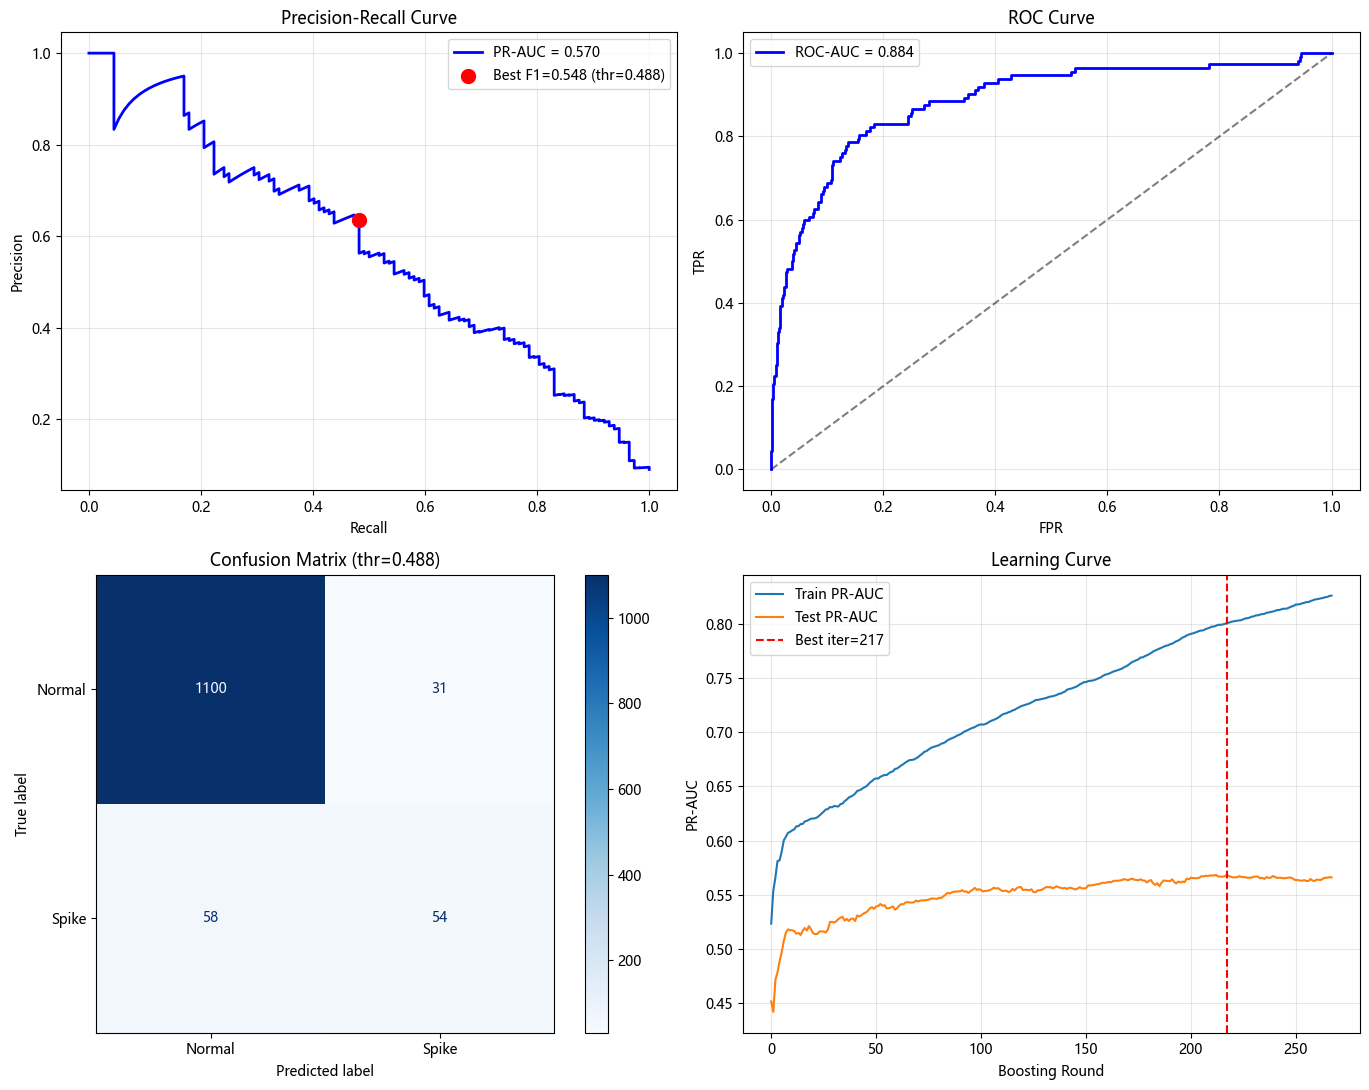

In [23]:
# ==================== 可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# 1. PR 曲线
ax = axes[0, 0]
ax.plot(recalls, precisions, 'b-', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
ax.scatter(recalls[best_idx], precisions[best_idx], c='r', s=100, zorder=5,
           label=f'Best F1={f1_scores[best_idx]:.3f} (thr={best_threshold:.3f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 2. ROC 曲线
ax = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax.plot(fpr, tpr, 'b-', lw=2, label=f'ROC-AUC = {roc_auc:.3f}')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 3. 混淆矩阵
ax = axes[1, 0]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Spike']).plot(ax=ax, cmap='Blues')
ax.set_title(f'Confusion Matrix (thr={best_threshold:.3f})')

# 4. 学习曲线
ax = axes[1, 1]
results = final_model.evals_result()
ax.plot(results['validation_0']['aucpr'], label='Train PR-AUC')
ax.plot(results['validation_1']['aucpr'], label='Test PR-AUC')
ax.axvline(final_model.best_iteration, color='r', linestyle='--',
           label=f'Best iter={final_model.best_iteration}')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('PR-AUC')
ax.set_title('Learning Curve')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

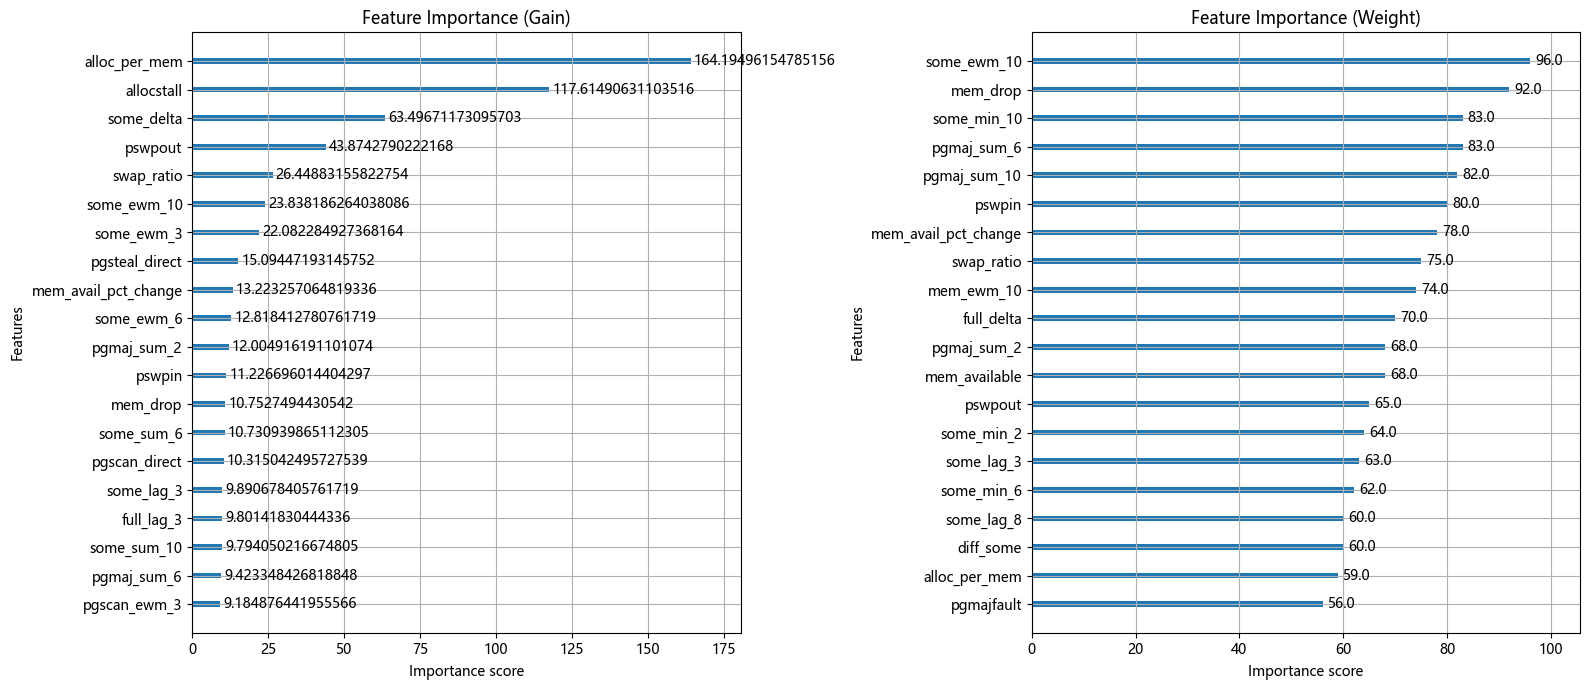

In [24]:
# ==================== 特征重要性 ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gain-based
xgb.plot_importance(final_model, importance_type='gain', max_num_features=20,
                    ax=axes[0], title='Feature Importance (Gain)')

# Weight-based (split 次数)
xgb.plot_importance(final_model, importance_type='weight', max_num_features=20,
                    ax=axes[1], title='Feature Importance (Weight)')

plt.tight_layout()
plt.show()

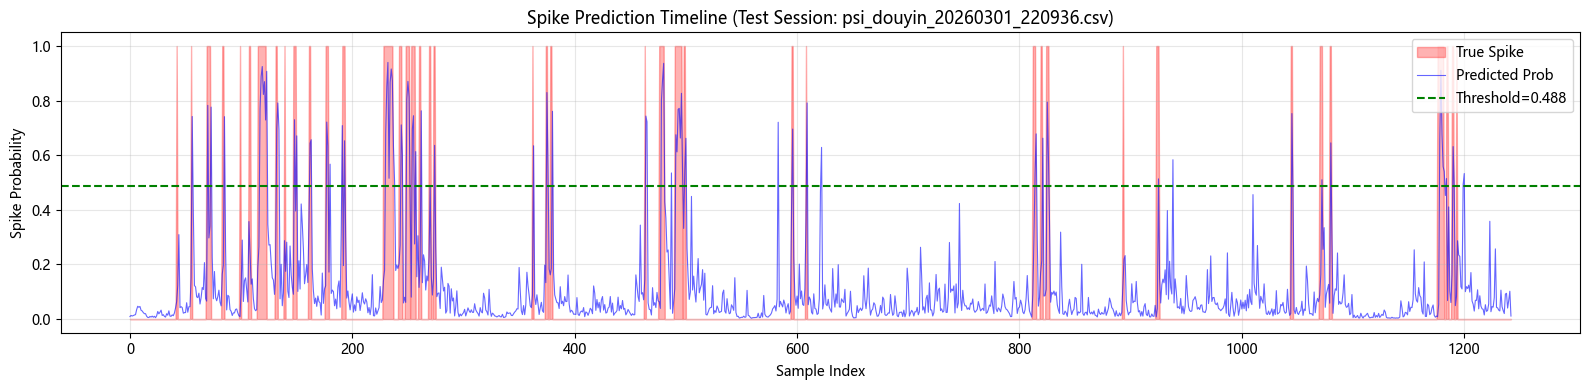

In [25]:
# ==================== 时序可视化：预测 vs 真实 ====================
fig, ax = plt.subplots(figsize=(16, 4))

ax.fill_between(range(len(y_test)), y_test.values, alpha=0.3, color='red', label='True Spike')
ax.plot(y_prob, color='blue', alpha=0.6, lw=0.8, label='Predicted Prob')
ax.axhline(best_threshold, color='green', linestyle='--', label=f'Threshold={best_threshold:.3f}')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Spike Probability')
ax.set_title(f'Spike Prediction Timeline (Test Session: {test_session})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# ==================== 事件级评估：突破 / 恢复 / 提前预警 ====================
# 不看逐样本准确率，而是以「一次完整 spike 事件」为单位来评估

TIME_PER_STEP = 0.5   # 每步约 0.5 秒 (采样间隔)
LOOK_BACK = 20        # 往前看 20 步 (10 秒) 搜索提前预警

true_seq = y_test.values          # 真实 binary 标签
pred_seq = y_pred                 # 模型预测 binary (最优 F1 阈值)
prob_seq = y_prob                 # 模型输出概率

# ───────── 1. 识别所有 spike 事件 (连续 is_spike=1 的区间) ─────────
events = []
in_event = False
for i in range(len(true_seq)):
    if true_seq[i] == 1 and not in_event:
        event_start = i
        in_event = True
    elif true_seq[i] == 0 and in_event:
        events.append((event_start, i - 1))
        in_event = False
if in_event:
    events.append((event_start, len(true_seq) - 1))

print(f"测试集: {len(true_seq)} 步, 采样间隔 ~{TIME_PER_STEP}s/步")
print(f"Spike 事件数: {len(events)}")
print(f"提前预警搜索窗口: {LOOK_BACK} 步 ({LOOK_BACK * TIME_PER_STEP:.0f}s)")
print("=" * 90)

# ───────── 2. 逐事件分析 ─────────
event_results = []

for idx, (start, end) in enumerate(events):
    duration_steps = end - start + 1
    duration_sec = duration_steps * TIME_PER_STEP

    # --- 突破检测: 模型在 start 或 start-1 处是否预测 1 ---
    breakthrough_hit = pred_seq[start] == 1
    # 放宽 ±1 步容差
    bt_range = slice(max(0, start - 1), min(len(pred_seq), start + 2))
    breakthrough_tolerant = any(pred_seq[bt_range] == 1)

    # --- 恢复检测: 事件结束后 (end+1 ~ end+2)  模型是否预测 0 ---
    if end + 1 < len(pred_seq):
        recovery_hit = pred_seq[end + 1] == 0
        rec_range = slice(end, min(len(pred_seq), end + 3))
        recovery_tolerant = any(pred_seq[rec_range] == 0)
    else:
        recovery_hit = None  # 事件延续到序列末尾
        recovery_tolerant = None

    # --- 提前预警: 从 start 往前找连续预测=1 的最远距离 ---
    lead_steps_consecutive = 0
    for j in range(start - 1, max(-1, start - LOOK_BACK - 1), -1):
        if pred_seq[j] == 1:
            lead_steps_consecutive += 1
        else:
            break
    lead_sec_consecutive = lead_steps_consecutive * TIME_PER_STEP

    # --- 提前预警 (首次信号): 在 look-back 窗口内最早出现 pred=1 的位置 ---
    look_start = max(0, start - LOOK_BACK)
    first_signal_idx = None
    for j in range(look_start, start):
        if pred_seq[j] == 1:
            first_signal_idx = j
            break
    if first_signal_idx is not None:
        lead_steps_first = start - first_signal_idx
        lead_sec_first = lead_steps_first * TIME_PER_STEP
    else:
        lead_steps_first = 0
        lead_sec_first = 0.0

    # --- 概率提前预警: 概率首次 > 0.5 的位置 (更灵敏) ---
    prob_first_idx = None
    for j in range(look_start, start):
        if prob_seq[j] > 0.5:
            prob_first_idx = j
            break
    prob_lead_sec = (start - prob_first_idx) * TIME_PER_STEP if prob_first_idx is not None else 0.0

    # --- 事件覆盖率: 模型在事件期间预测为 1 的比例 ---
    event_coverage = pred_seq[start:end + 1].mean()

    event_results.append({
        'event_id': idx + 1,
        'start': start, 'end': end,
        'duration_sec': duration_sec,
        'breakthrough_hit': breakthrough_hit,
        'breakthrough_tolerant': breakthrough_tolerant,
        'recovery_hit': recovery_hit,
        'recovery_tolerant': recovery_tolerant,
        'lead_sec_consecutive': lead_sec_consecutive,
        'lead_sec_first_signal': lead_sec_first,
        'prob_lead_sec': prob_lead_sec,
        'event_coverage': event_coverage,
    })

    # 打印每个事件
    bt_icon = '✓' if breakthrough_hit else ('~' if breakthrough_tolerant else '✗')
    rc_icon = ('✓' if recovery_hit else ('~' if recovery_tolerant else '✗')) if recovery_hit is not None else '-'
    print(f"事件 #{idx+1:2d} | 步骤[{start:4d},{end:4d}] 持续{duration_sec:5.1f}s | "
          f"突破{bt_icon} 恢复{rc_icon} | "
          f"提前预警: 连续{lead_sec_consecutive:4.1f}s, 首信号{lead_sec_first:4.1f}s, "
          f"概率>{0.5:.1f}={prob_lead_sec:4.1f}s | "
          f"覆盖率{event_coverage:.0%}")

# ───────── 3. 汇总统计 ─────────
n_events = len(event_results)
bt_exact = sum(e['breakthrough_hit'] for e in event_results)
bt_toler = sum(e['breakthrough_tolerant'] for e in event_results)
rc_valid = [e for e in event_results if e['recovery_hit'] is not None]
rc_exact = sum(e['recovery_hit'] for e in rc_valid)
rc_toler = sum(e['recovery_tolerant'] for e in rc_valid)

lead_cons = [e['lead_sec_consecutive'] for e in event_results]
lead_first = [e['lead_sec_first_signal'] for e in event_results]
prob_leads = [e['prob_lead_sec'] for e in event_results]
coverages = [e['event_coverage'] for e in event_results]

events_with_early_warning = sum(1 for l in lead_first if l > 0)

print("\n" + "=" * 90)
print(f"{'事件级评估汇总':^90}")
print("=" * 90)
print(f"  Spike 事件总数:          {n_events}")
print(f"  突破检测率 (精确):       {bt_exact}/{n_events} = {bt_exact/n_events:.1%}")
print(f"  突破检测率 (±1步容差):   {bt_toler}/{n_events} = {bt_toler/n_events:.1%}")
if rc_valid:
    print(f"  恢复检测率 (精确):       {rc_exact}/{len(rc_valid)} = {rc_exact/len(rc_valid):.1%}")
    print(f"  恢复检测率 (±1步容差):   {rc_toler}/{len(rc_valid)} = {rc_toler/len(rc_valid):.1%}")
print(f"  有提前预警的事件:        {events_with_early_warning}/{n_events} = {events_with_early_warning/n_events:.1%}")
print(f"  平均提前预警 (连续):     {np.mean(lead_cons):.1f}s (max={np.max(lead_cons):.1f}s)")
print(f"  平均提前预警 (首信号):   {np.mean(lead_first):.1f}s (max={np.max(lead_first):.1f}s)")
print(f"  平均概率预警 (prob>0.5): {np.mean(prob_leads):.1f}s (max={np.max(prob_leads):.1f}s)")
print(f"  事件期间平均覆盖率:      {np.mean(coverages):.1%}")
print("=" * 90)

测试集: 1243 步, 采样间隔 ~0.5s/步
Spike 事件数: 41
提前预警搜索窗口: 20 步 (10s)
事件 # 1 | 步骤[  42,  42] 持续  0.5s | 突破✗ 恢复✓ | 提前预警: 连续 0.0s, 首信号 0.0s, 概率>0.5= 0.0s | 覆盖率0%
事件 # 2 | 步骤[  55,  55] 持续  0.5s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号 0.0s, 概率>0.5= 0.0s | 覆盖率0%
事件 # 3 | 步骤[  69,  72] 持续  2.0s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号 6.5s, 概率>0.5= 6.5s | 覆盖率25%
事件 # 4 | 步骤[  83,  84] 持续  1.0s | 突破✗ 恢复~ | 提前预警: 连续 0.0s, 首信号 6.5s, 概率>0.5= 6.5s | 覆盖率0%
事件 # 5 | 步骤[  99,  99] 持续  0.5s | 突破✗ 恢复✓ | 提前预警: 连续 0.0s, 首信号 7.0s, 概率>0.5= 7.0s | 覆盖率0%
事件 # 6 | 步骤[ 107, 108] 持续  1.0s | 突破✗ 恢复✓ | 提前预警: 连续 0.0s, 首信号 0.0s, 概率>0.5= 0.0s | 覆盖率0%
事件 # 7 | 步骤[ 115, 122] 持续  4.0s | 突破✗ 恢复~ | 提前预警: 连续 0.0s, 首信号 0.0s, 概率>0.5= 0.0s | 覆盖率75%
事件 # 8 | 步骤[ 131, 132] 持续  1.0s | 突破~ 恢复✗ | 提前预警: 连续 0.0s, 首信号 7.0s, 概率>0.5= 7.0s | 覆盖率50%
事件 # 9 | 步骤[ 139, 139] 持续  0.5s | 突破✗ 恢复✓ | 提前预警: 连续 0.0s, 首信号10.0s, 概率>0.5=10.0s | 覆盖率0%
事件 #10 | 步骤[ 147, 149] 持续  1.5s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号 7.5s, 概率>0.5= 7.5s | 覆盖率33%
事件 #11 | 步骤[ 161, 162] 持续  1.0s | 突

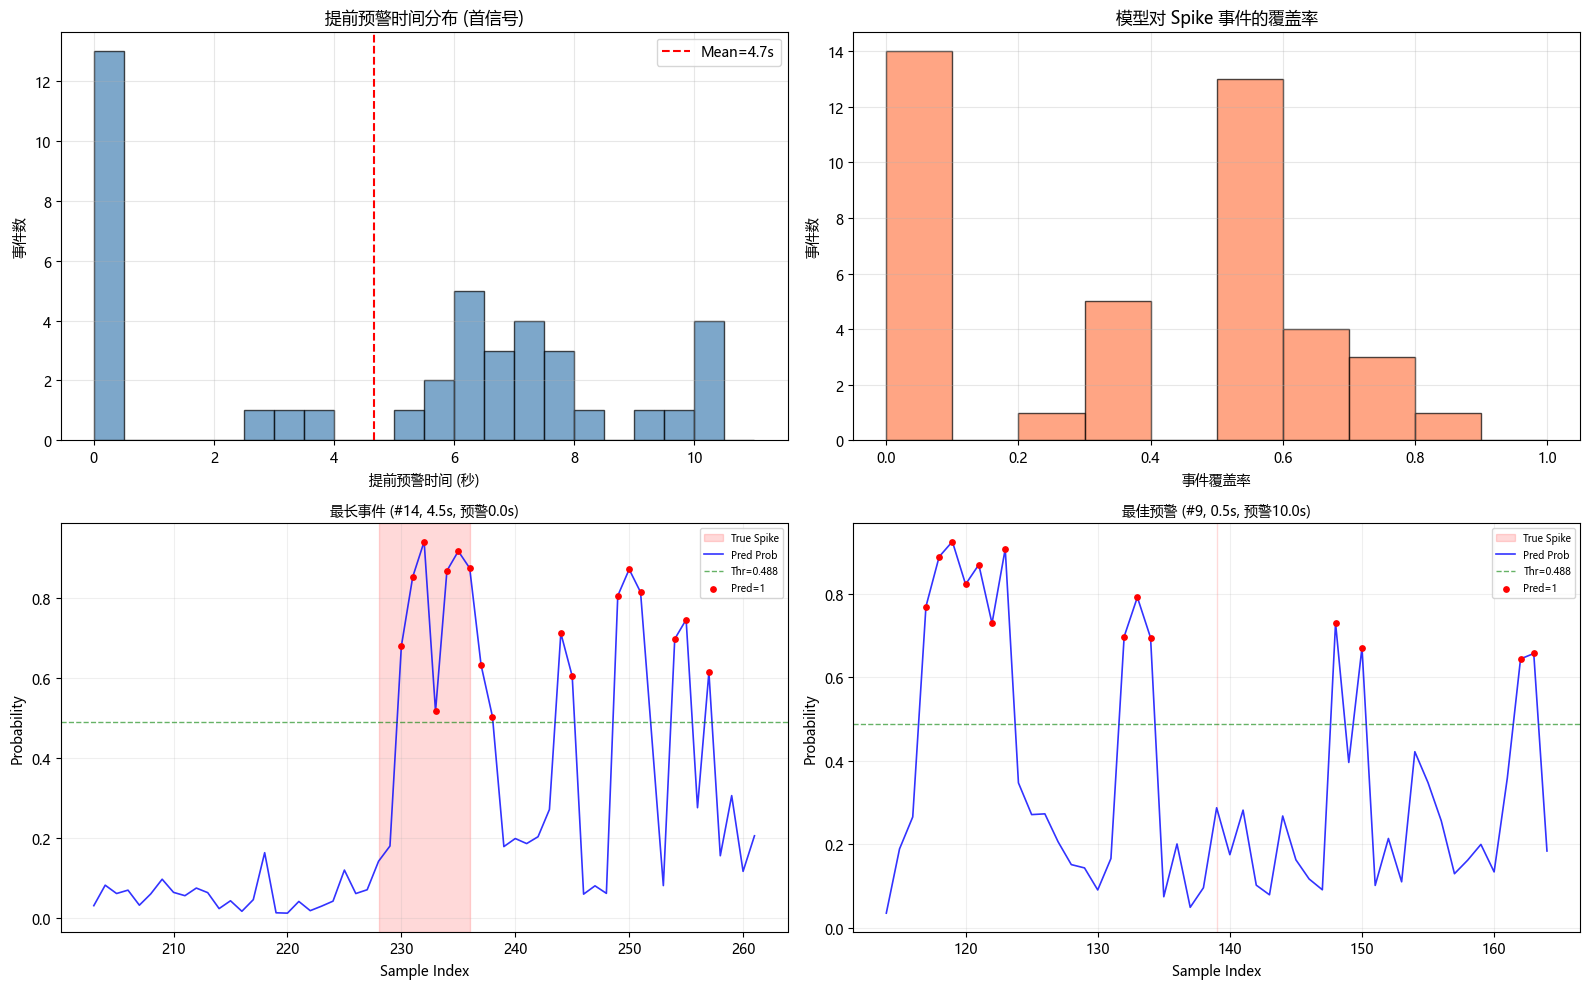

In [27]:
# ==================== 事件级可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ─── 1. 提前预警时间分布 ───
ax = axes[0, 0]
lead_data = [e['lead_sec_first_signal'] for e in event_results]
bins_lead = np.arange(0, max(lead_data) + 1.5, 0.5)
ax.hist(lead_data, bins=bins_lead, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(lead_data), color='red', linestyle='--', label=f'Mean={np.mean(lead_data):.1f}s')
ax.set_xlabel('提前预警时间 (秒)')
ax.set_ylabel('事件数')
ax.set_title('提前预警时间分布 (首信号)')
ax.legend()
ax.grid(True, alpha=0.3)

# ─── 2. 事件覆盖率分布 ───
ax = axes[0, 1]
ax.hist([e['event_coverage'] for e in event_results], bins=10,
        color='coral', edgecolor='black', alpha=0.7, range=(0, 1))
ax.set_xlabel('事件覆盖率')
ax.set_ylabel('事件数')
ax.set_title('模型对 Spike 事件的覆盖率')
ax.grid(True, alpha=0.3)

# ─── 3. 逐事件时序放大 (选 3 个代表性事件) ───
# 选 duration 最长的、提前预警最多的、和一个漏检的
if len(event_results) >= 3:
    # 最长事件
    longest = max(event_results, key=lambda e: e['duration_sec'])
    # 提前预警最多
    best_warning = max(event_results, key=lambda e: e['lead_sec_first_signal'])
    # 覆盖率最低 (最难检测)
    hardest = min(event_results, key=lambda e: e['event_coverage'])
    showcases = [
        (longest, '最长事件'),
        (best_warning, '最佳预警'),
        (hardest, '最难检测'),
    ]
else:
    showcases = [(event_results[i], f'事件#{i+1}') for i in range(min(3, len(event_results)))]

# 去重
seen_ids = set()
unique_showcases = []
for e, label in showcases:
    if e['event_id'] not in seen_ids:
        seen_ids.add(e['event_id'])
        unique_showcases.append((e, label))
showcases = unique_showcases[:3]

for plot_idx, (ev, label) in enumerate(showcases):
    if plot_idx >= 2:
        break
    ax = axes[1, plot_idx]
    margin = 25  # 前后各 25 步
    s = max(0, ev['start'] - margin)
    e_end = min(len(true_seq), ev['end'] + margin + 1)
    x = np.arange(s, e_end)
    
    # 真实 spike 区间背景
    ax.axvspan(ev['start'], ev['end'], alpha=0.15, color='red', label='True Spike')
    # 预测概率
    ax.plot(x, prob_seq[s:e_end], 'b-', lw=1.2, alpha=0.8, label='Pred Prob')
    # 决策阈值
    ax.axhline(best_threshold, color='green', linestyle='--', lw=1, alpha=0.6,
               label=f'Thr={best_threshold:.3f}')
    # 预测为 spike 的点
    pred_mask = pred_seq[s:e_end] == 1
    ax.scatter(x[pred_mask], prob_seq[s:e_end][pred_mask], c='red', s=15, zorder=5, label='Pred=1')
    
    ax.set_title(f'{label} (#{ev["event_id"]}, {ev["duration_sec"]:.1f}s, 预警{ev["lead_sec_first_signal"]:.1f}s)',
                 fontsize=10)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.2)

# 如果不足3个事件，隐藏多余的子图
if len(showcases) < 2:
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

In [31]:
# ==================== 导出模型 ====================
import json, os

os.makedirs("../model", exist_ok=True)

# 1. 保存模型
final_model.save_model("../model/spike_classifier.json")
final_model.save_model("../model/spike_classifier.bin")

# 2. 保存元数据（推理时需要）
meta = {
    'feature_cols': feature_cols,
    'spike_threshold_us': float(THRESHOLD),
    'decision_threshold': float(best_threshold),
    'metrics': {
        'pr_auc': float(pr_auc),
        'roc_auc': float(roc_auc),
        'f1': float(f1_scores[best_idx]),
        'precision': float(precisions[best_idx]),
        'recall': float(recalls[best_idx]),
    },
    'best_iteration': int(final_model.best_iteration),
    'best_params': study.best_params
}

with open("../model/spike_classifier_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"模型已保存")
print(f"特征数: {len(feature_cols)}")
print(f"Spike 阈值: {THRESHOLD:.0f} μs")
print(f"决策阈值: {best_threshold:.4f}")

模型已保存
特征数: 43
Spike 阈值: 100000 μs
决策阈值: 0.6272
